In [46]:
import requests
import pandas as pd
import wbdata
import datetime

indicators = {
    "NY.GDP.MKTP.KD.ZG": "GDP_growth", #target
    "NY.GDP.PCAP.CD": "GDP per Capita",  # GDP per capita (current US$)
    "FP.CPI.TOTL.ZG": "Inflation",  # Inflation, consumer prices (annual %)
    "SL.UEM.TOTL.ZS": "Unemployment",  # Unemployment, total (% of total labor force)
    "FR.INR.RINR": "Interest Rate"  # Real interest rate (%)
}

country_codes = ["US", "GB", "JP", "EU", "AU", "CA"]

start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime.today()

data = wbdata.get_dataframe(
    indicators,
    country=country_codes,
    data_date=(start_date, end_date),
    convert_date=False,
    keep_levels=True
)
data.reset_index(inplace=True)
data.dropna(inplace=True)

print(data.head())

     country  date  GDP_growth  GDP per Capita  Inflation  Unemployment  \
2  Australia  2019    2.171396    54941.434179   1.610768          5.16   
3  Australia  2018    2.883045    57207.871509   1.911401          5.30   
4  Australia  2017    2.282184    53936.140255   1.948647          5.59   
5  Australia  2016    2.730548    49875.565143   1.276991          5.71   
6  Australia  2015    2.152736    56710.445724   1.508367          6.05   

   Interest Rate  
2       1.647306  
3       3.370036  
4       1.448037  
5       6.062701  
6       6.206222  


In [61]:
#Feature Selection
import numpy as np

def calculate_moving_average(df, column_name, window=3):
    return df[column_name].rolling(window=window).mean()

def calculate_ema(df, column_name, window=12):
    data = df[column_name]
    return data.ewm(span=window).mean()

def calculate_roc(df, column_name):
    return df[column_name].pct_change()

def calculate_rsi(df, column_name, window=14):
    data = df[column_name]
    delta = data.diff().dropna()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    avg_gain = gains.rolling(window=window).mean()
    avg_loss = losses.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [73]:
#Model training & prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def random_forest_model(country):
    X = country[["Inflation", "Unemployment", "Interest Rate", 'GDP per Capita',
                'Inflation_MA', 'Inflation_EMA', 'Inflation_ROC', 
                'Unemployment_MA', 'Unemployment_EMA', 'Unemployment_ROC', 
                'Interest Rate_MA', 'Interest Rate_EMA', 'Interest Rate_ROC', 
                'GDP per Capita_MA', 'GDP per Capita_EMA', 'GDP per Capita_ROC']]
    y = country["GDP_growth"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    #cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    n_features = X_train.shape[1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(n_features), feature_importances[sorted_idx])
    plt.yticks(range(n_features), X_train.columns[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances in Random Forest Model')
    plt.show()

    return model, mse

/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_MA"] = calculate_moving_average(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_EMA"] = calculate_ema(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:23: SettingWithCopyWarning: 
A value 

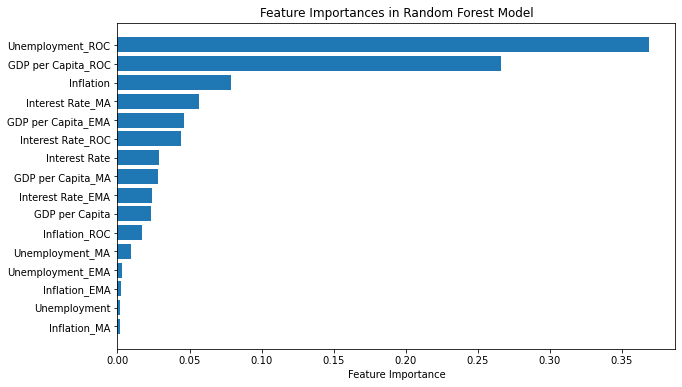

United States: Mean Squared Error = 1.073669750556078


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_MA"] = calculate_moving_average(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_EMA"] = calculate_ema(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:23: SettingWithCopyWarning: 
A value 

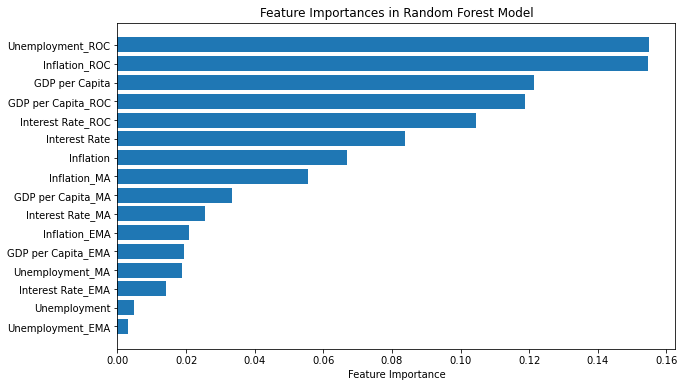

United Kingdom: Mean Squared Error = 1.084213577472547


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_MA"] = calculate_moving_average(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_EMA"] = calculate_ema(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:23: SettingWithCopyWarning: 
A value 

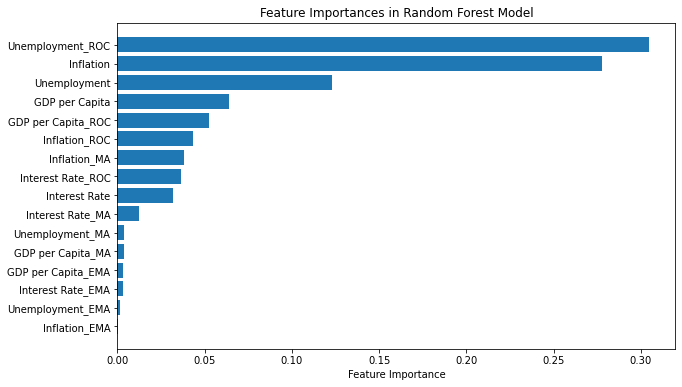

Japan: Mean Squared Error = 0.21971929237248142
Skipping European Union due to insufficient data points.


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_MA"] = calculate_moving_average(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_EMA"] = calculate_ema(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:23: SettingWithCopyWarning: 
A value 

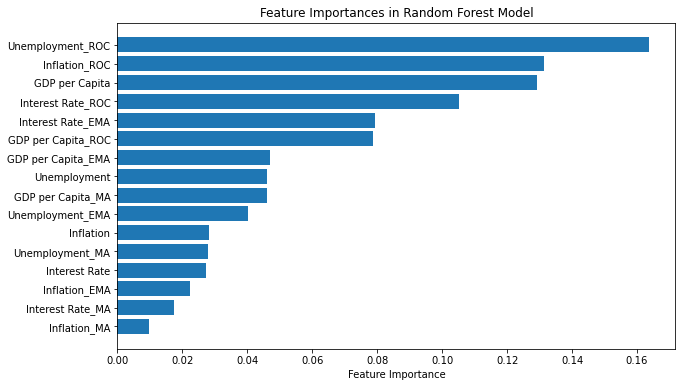

Australia: Mean Squared Error = 0.4561132802726502


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_MA"] = calculate_moving_average(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country[f"{indicator}_EMA"] = calculate_ema(country, indicator)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_55304/3896017862.py:23: SettingWithCopyWarning: 
A value 

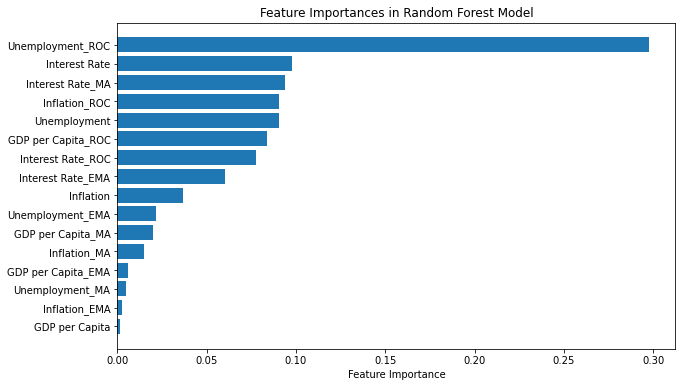

Canada: Mean Squared Error = 0.31460643310368386
Empty WBDataFrame
Columns: [country, date, GDP_growth, GDP per Capita, Inflation, Unemployment, Interest Rate]
Index: []


In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data.sort_values(by="date", ascending=True, inplace=True)

country_data = {}
for country_code in country_codes:
    country_name = wbdata.get_country(country_code)[0]["name"]
    country_data[country_name] = data[data["country"] == country_name]

min_data_points = 10
results = {}

for country_name, country in country_data.items():
    if len(country) < min_data_points:
        print(f"Skipping {country_name} due to insufficient data points.")
        continue
        
    for indicator in ["Inflation", "Unemployment", "Interest Rate", 'GDP per Capita']:
        country[f"{indicator}_MA"] = calculate_moving_average(country, indicator)
        country[f"{indicator}_EMA"] = calculate_ema(country, indicator)
        country[f"{indicator}_ROC"] = calculate_roc(country, indicator)
        #country[f"{indicator}_RSI"] = calculate_rsi(country, indicator)
    
    
    country.dropna(inplace=True)
    
    model, mse = random_forest_model(country)
    results[country_name] = {
        "model": model,
        "mse": mse
    }

    print(f"{country_name}: Mean Squared Error = {mse}")